# Capstone 1: EDA- Inferential Statistics

In [1]:
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime
from scipy.stats import stats
from scipy.stats import norm
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.proportion import proportions_ztest
import re
import os

In [2]:
#gamelogs3 was made in DataWrangling 2 and includes the averages for the teams as well as the raw data
infile = open('../PickledFiles/gamelogs3','rb')
gamelogs = pickle.load(infile)
infile.close()

## Does the away team's offense strike out more than the home team's?

HYPOTHESIS TEST: <br>
Null hypothesis: The home team and the visiting team strike out the same number of times. <br>
$H_0$: $\mu_a$ = $\mu_h$ <br>
Alternate hypothesis:  They away team strikes out more than the visiting team. <br>
$H_A$: $\mu_a$ > $\mu_h$  <br>
$\alpha$ = 0.01

## Is the proportion of home games won by American League teams the same as the proportion of home games won by National League teams?

Null hypothesis: There is no difference in proportion of home games won by American League teams and National League teams. <br>
$H_{0}$: $p_{AL}$ = $p_{NL}$ <br>
Alternate hypothesis: There is a difference in the proportion. <br>
$H_{A}$: $p_{AL}$  $\neq$ $p_{NL}$ <br>
$\alpha$ = 0.01

In [3]:
AL_home = gamelogs[gamelogs['HomeTeamLeague']=='AL']
NL_home = gamelogs[gamelogs['HomeTeamLeague']=='NL']
p_al_homewin = sum(AL_home['HomeWin'])/len(AL_home['HomeWin'])
p_nl_homewin = sum(NL_home['HomeWin'])/len(NL_home['HomeWin'])
p_pooled = sum(gamelogs.HomeWin)/len(gamelogs.HomeWin)
print('In the 2009-2018 seasons, American League teams won ' + str(round(p_al_homewin*100,3)) + '% of their home games.')
print('National League teams won ' + str(round(p_nl_homewin*100,3)) + '% of their home games.')

In the 2009-2018 seasons, American League teams won 53.974% of their home games.
National League teams won 53.488% of their home games.


### Frequentist approach

In [4]:
print('Frequentist Approach:')
pooled_p = sum(gamelogs.HomeWin)/len(gamelogs.HomeWin)
diff_obs = p_al_homewin - p_nl_homewin
print('Observed difference: ', diff_obs)

z_star = norm.ppf(0.995)

moe = z_star * np.sqrt((pooled_p)*(1-pooled_p)/len(gamelogs.HomeWin))
print('margin of error: ', moe)

conf_int = (diff_obs - moe,  diff_obs + moe)
print('99% confindence interval: ', conf_int)

count = [sum(AL_home.HomeWin), sum(NL_home.HomeWin)]
nobs = [len(AL_home.HomeWin), len(NL_home.HomeWin)]
z, p_z = proportions_ztest(count, nobs)


print('p-value: ', p_z)

Frequentist Approach:
Observed difference:  0.0048648122818282236
margin of error:  0.008239360604482018
99% confindence interval:  (-0.003374548322653794, 0.013104172886310241)
p-value:  0.4471577972264821


### Bootstrapping approach

In [5]:
print('Bootstrap Approach:')
bs_reps = np.empty(100000)
for i in range(100000):
    bs_sample_AL = np.random.binomial(n=1, p = pooled_p, size = len(AL_home.HomeWin))
    bs_sample_NL = np.random.binomial(n=1, p = pooled_p, size = len(NL_home.HomeWin))
    bs_reps[i] = sum(bs_sample_AL)/len(bs_sample_AL) - sum(bs_sample_NL)/len(bs_sample_NL)

diff_obs = p_al_homewin - p_nl_homewin
print('Observed difference: ', diff_obs)


#95% confidence interval    
bs_confint = np.percentile(bs_reps, [0.5, 99.5])
print('Bootstrap 99% confidence interval: ', bs_confint)

#p-value
p_val = 2*np.sum(bs_reps >= diff_obs)/100000
print('The p-value is ', p_val)

Bootstrap Approach:
Observed difference:  0.0048648122818282236
Bootstrap 99% confidence interval:  [-0.01636028  0.0163248 ]
The p-value is  0.44088


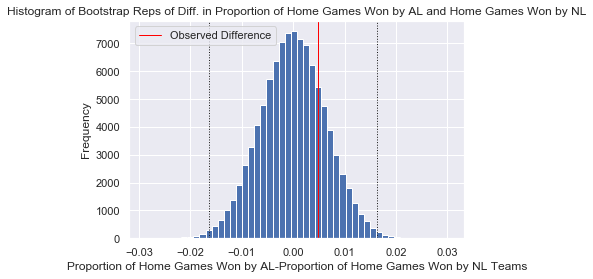

In [6]:
sns.set()
plt.hist(bs_reps, bins = 50)
plt.axvline(bs_confint[0], color='k', linestyle = 'dotted', linewidth=1)
plt.axvline(bs_confint[1], color='k', linestyle = 'dotted', linewidth=1)
plt.axvline(diff_obs, color='red', linewidth=1, label = 'Observed Difference')
plt.title('Histogram of Bootstrap Reps of Diff. in Proportion of Home Games Won by AL and Home Games Won by NL')
plt.xlabel('Proportion of Home Games Won by AL-Proportion of Home Games Won by NL Teams')
plt.ylabel('Frequency')
plt.legend()

We see that both the frequentist approach and the bootstrap approach result in a p-value of about 0.44 which is much higher than 0.01. We do not have enough eveidence to reject the null hypothesis, that is, there is not enough evidence to suggest that there is a difference in proportion of home games won by the American League and the proportion of games won by the National League.

## Do teams typically have higher OBPs at home than on the road?

HYPOTHESIS TEST: <br>
Null hypothesis: The home team and the visiting team have the same OBP. <br>
$H_0$: $\mu_h$ = $\mu_a$ <br>
Alternate hypothesis:  On average, the home team's On-Base Percentage is higher than the visiting team's . <br>
$H_A$: $\mu_h$ > $\mu_a$  <br>
$\alpha$ = 0.01

In [7]:
temp_df = pd.DataFrame()
temp_df['HomeOBP'] = gamelogs['HomeRB']/gamelogs['HomePA']
temp_df['VisitorOBP'] = gamelogs['VisitorRB']/gamelogs['VisitorPA']

Since the sample size is large (n >23,000 > > 30) and observations are independent, the Central Limit Theorem applies.

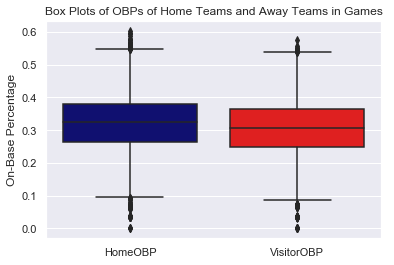

In [8]:

sns.boxplot(data = temp_df, palette=['navy','red'])
plt.ylabel('On-Base Percentage')
plt.title('Box Plots of OBPs of Home Teams and Away Teams in Games')
plt.show()

In [9]:
temp_df.describe()

,HomeOBP,VisitorOBP
count,24298.000000,24298.000000
mean,0.321207,0.306699
std,0.083791,0.080745
min,0.000000,0.000000
25%,0.264706,0.250000
50%,0.323529,0.307692
75%,0.378378,0.365854
max,0.603448,0.574074


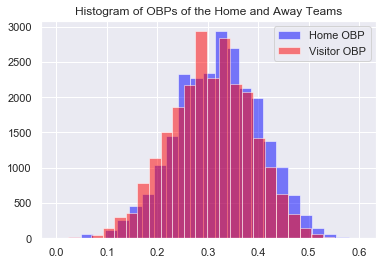

In [10]:
plt.hist(temp_df.HomeOBP, bins = 25, color = 'blue', alpha=0.5, label='Home OBP')
plt.hist(temp_df.VisitorOBP, bins = 25,color = 'red', alpha=0.5, label='Visitor OBP')
plt.title('Histogram of OBPs of the Home and Away Teams')
plt.legend(loc='upper right')

From both the boxplots and the pverlapping histograms it seems that home teams have slighlty higher on-base percentages, on average than away teams.  Let's test the statistical significance of this using a two-sample z-test.

In [11]:
#Frequentist Approach
HomeOBP = temp_df.HomeOBP
VisitOBP = temp_df.VisitorOBP
test_stat = np.mean(HomeOBP) - np.mean(VisitOBP)

#frequentist approach
std_dev_diff = np.sqrt((np.std(HomeOBP)/len(HomeOBP))+(np.std(VisitOBP)/len(VisitOBP)))

z_star = norm.ppf(0.995)


moe = z_star * std_dev_diff
conf_int = (test_stat-moe, test_stat+moe)
print('Observed Diff in Means: ', test_stat)
print('Margin of error: ', moe)
print('99% confidence interval: ', conf_int)




Observed Diff in Means:  0.014507964328006495
Margin of error:  0.0067028180736067025
99% confidence interval:  (0.007805146254399793, 0.0212107824016132)


We are 99% confident that the difference between the home team's on-base percentage and that of the away team is between 0.78% and 2.12%. Since 0 is not in this interval, we can reject the null hypothesis.

In [12]:
#two-sided, two-sample hypothesis test
z, p_z = ztest(HomeOBP, VisitOBP, alternative = 'larger')

print('z-score: ', z)
print('p-value: ', p_z)


z-score:  19.43444703567863
p-value:  1.973218676315e-84


Similarly, the p-value from the z-test is very small, much smaller than the significance level of 0.01, so we can reject the null-hypothesis, and that conclude there is a statisticially significant difference in OBPs of home teams and away teams in games.  The home team has a higher OBP.  There is a large sample size (n,m=24298) so we it is not this could be why we are seeing a statistically significant differnce.

## Do pitchers typically allow fewer earned runs at home games (adjusting for 9 innings)?

HYPOTHESIS TEST: <br>
Null hypothesis: On average, the home team and the visiting team pitchers allow the same number of runs in a game. <br>
$H_0$: $\mu_h$ = $\mu_a$ <br>
Alternate hypothesis:  The home team pitchers allow fewer runs. <br>
$H_A$: $\mu_h$ < $\mu_a$  <br>
$\alpha$ = 0.01

In [13]:
ERs = pd.DataFrame()
ERs['HomeAdjER'] = gamelogs.HomeER * 9 / gamelogs.HomeDefInnings
ERs['VisitAdjER'] = gamelogs.VisitorER * 9 / gamelogs.VisitorDefInnings


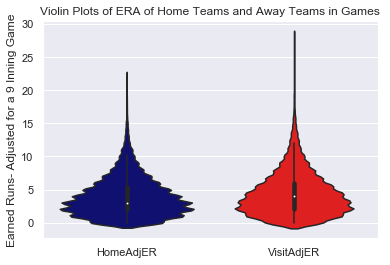

In [14]:
sns.violinplot(data = ERs, palette=['navy','red'])
plt.ylabel('Earned Runs- Adjusted for a 9 Inning Game')
plt.title('Violin Plots of ERA of Home Teams and Away Teams in Games')
plt.show()

Based on the violin plots, the number of runs allowed by the home team seem to be denser at lower numbers of earned runs.

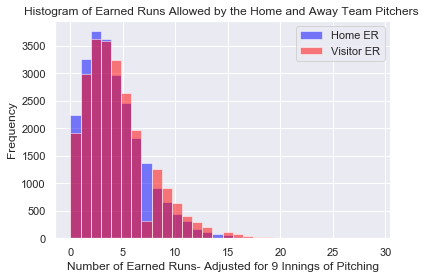

In [15]:
plt.hist(ERs.HomeAdjER, bins = 30, color = 'blue', range = [0,29], alpha=0.5, label='Home ER')
plt.hist(ERs.VisitAdjER, bins = 30,color = 'red', range = [0,29], alpha=0.5, label='Visitor ER')
plt.title('Histogram of Earned Runs Allowed by the Home and Away Team Pitchers ')
plt.xlabel('Number of Earned Runs- Adjusted for 9 Innings of Pitching')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

In [16]:
ERs.describe()

,HomeAdjER,VisitAdjER
count,24298.00000,24298.000000
mean,3.89795,4.388120
std,2.92787,3.281304
min,0.00000,0.000000
25%,2.00000,2.000000
50%,3.00000,4.000000
75%,5.40000,6.000000
max,22.00000,28.125000


It seems the home teams allow fewer earned runs per 9 innings.  Let's test the hypothesis from above.

In [17]:
z, p_z = ztest(ERs['HomeAdjER'], ERs['VisitAdjER'], alternative = 'smaller')

print('z-score: ', z)
print('p-value: ', p_z)

z-score:  -17.37444544875902
p-value:  6.442291611567506e-68


The p-value is very small.  We can reject the null hypothesis, and conclude that there is a significant difference between the number of earned runs of home team at home and away teams-  pitchers tend to allow fewer earned runs at home games.

## Does winning team team's starting pitcher tend to have lower ERA entering the game than the losing team?

HYPOTHESIS TEST: <br>
Null hypothesis: On average, the winning team's starting pitcher and the losing team's starting pitcher have the same ERA before the game starts. <br>
$H_0$: $\mu_w$ = $\mu_l$ <br>
Alternate hypothesis:  The winning team's starting pitcher enter the game with a better (lower) earned run average than the losing team's starting pitcher. <br>
$H_A$: $\mu_w$ < $\mu_l$  <br>
$\alpha$ = 0.01

In [18]:
winnersStartingERAs = []
losersStartingERAs = []
for i, game in gamelogs.iterrows():
    if game['HomeWin'] == 1:
        winnerStartingERA = game['AvgERA_HSP']
        loserStartingERA = game['AvgERA_VSP']
    else:
        winnerStartingERA = game['AvgERA_VSP']
        loserStartingERA = game['AvgERA_HSP']
    winnersStartingERAs.append(winnerStartingERA)
    losersStartingERAs.append(loserStartingERA)

In [19]:
SP_ERAs = pd.DataFrame(columns= ['winnersSP_ERAs','losersSP_ERAs'])
SP_ERAs['winnersSP_ERAs'] = winnersStartingERAs
SP_ERAs['losersSP_ERAs'] = losersStartingERAs

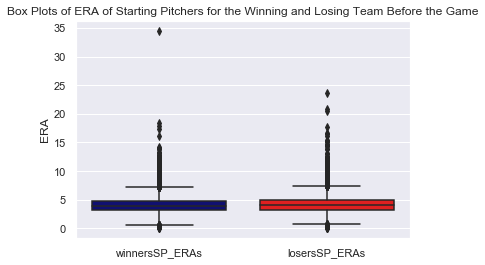

In [20]:
sns.boxplot(data = SP_ERAs, palette=['navy','red'])
plt.ylabel('ERA')
plt.title('Box Plots of ERA of Starting Pitchers for the Winning and Losing Team Before the Game')
plt.show()

/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


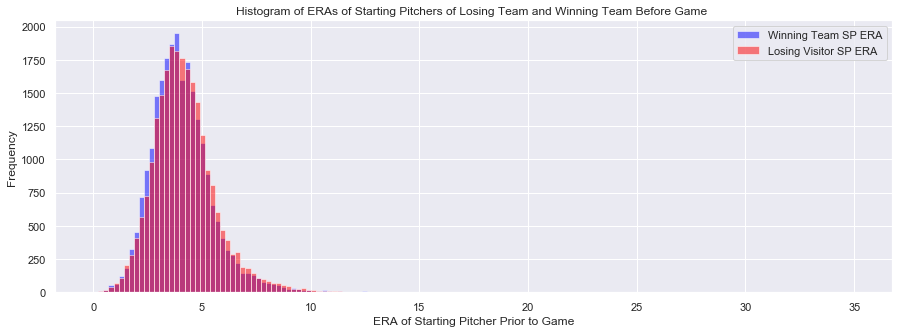

In [21]:
plt.figure(figsize=(15,5))
plt.hist(SP_ERAs['winnersSP_ERAs'], bins = 150, color = 'blue', alpha=0.5, range = [0,35], label='Winning Team SP ERA')
plt.hist(SP_ERAs['losersSP_ERAs'], bins = 150,color = 'red', alpha=0.5, range = [0,35],label='Losing Visitor SP ERA')
plt.title('Histogram of ERAs of Starting Pitchers of Losing Team and Winning Team Before Game ')
plt.xlabel('ERA of Starting Pitcher Prior to Game')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

In [22]:
SP_ERAs.describe()

,winnersSP_ERAs,losersSP_ERAs
count,24221.000000,24225.000000
mean,4.064136,4.198000
std,1.441772,1.482002
min,0.000000,0.000000
25%,3.130435,3.243506
50%,3.905660,4.039370
75%,4.790323,4.925676
max,34.500000,23.625000


In [23]:
# hypothesis test
z, p_z = ztest(SP_ERAs['winnersSP_ERAs'], SP_ERAs['losersSP_ERAs'], alternative = 'smaller')

print('z-score: ', z)
print('p-value: ', p_z)

z-score:  nan
p-value:  nan


In [24]:
tempSP_ERAs = SP_ERAs.dropna(axis=0)

In [25]:
z, p_z = ztest(tempSP_ERAs['winnersSP_ERAs'], tempSP_ERAs['losersSP_ERAs'], alternative = 'smaller')

print('z-score: ', z)
print('p-value: ', p_z)

z-score:  -10.049416292719139
p-value:  4.620658660114838e-24


We can reject the null hypothesis.  There is a statistically significant difference between the ERAs of the Starting pitcher of the team that wins the game and that of the team that loses the games.

### On average, does winning team team's starting pitcher have lower FIP entering the game than the losing team?

HYPOTHESIS TEST: <br>
Null hypothesis: On average, the winning team's starting pitcher and the losing team's starting pitcher have the same FIP before the game starts. <br>
$H_0$: $\mu_w$ = $\mu_l$ <br>
Alternate hypothesis:  The winning team's starting pitcher enter the game with a better (lower) fielding independent pitching than the losing team's starting pitcher. <br>
$H_A$: $\mu_w$ < $\mu_l$  <br>
$\alpha$ = 0.01

In [26]:
winnersStartingFIPs = []
losersStartingFIPs = []
for i, game in gamelogs.iterrows():
    if game['HomeWin'] == 1:
        winnerStartingFIP = game['AvgFIPnoConst_HSP']
        loserStartingFIP = game['AvgFIPnoConst_VSP']
    else:
        winnerStartingFIP = game['AvgFIPnoConst_VSP']
        loserStartingFIP = game['AvgFIPnoConst_HSP']
    winnersStartingFIPs.append(winnerStartingFIP)
    losersStartingFIPs.append(loserStartingFIP)

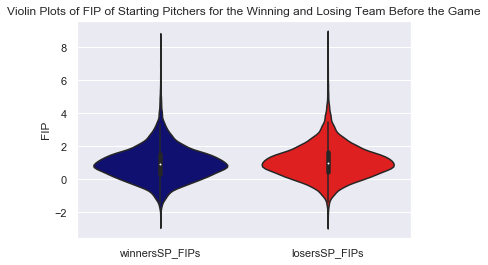

In [27]:
SP_FIPs = pd.DataFrame(columns= ['winnersSP_FIPs','losersSP_FIPs'])
SP_FIPs['winnersSP_FIPs'] = winnersStartingFIPs
SP_FIPs['losersSP_FIPs'] = losersStartingFIPs


sns.violinplot(data = SP_FIPs, palette=['navy','red'])
plt.ylabel('FIP')
plt.title('Violin Plots of FIP of Starting Pitchers for the Winning and Losing Team Before the Game')
plt.show()

In [28]:
SP_FIPs.describe()

,winnersSP_FIPs,losersSP_FIPs
count,24221.000000,24225.000000
mean,0.976458,1.092373
std,1.005705,1.015436
min,-2.666667,-2.700000
25%,0.317518,0.431507
50%,0.909774,1.015385
75%,1.529228,1.641379
max,8.597938,8.742857


In [29]:
tempSP_FIPs = SP_FIPs.dropna(axis=0)

In [30]:
tempSP_FIPs.describe()

,winnersSP_FIPs,losersSP_FIPs
count,24219.000000,24219.000000
mean,0.976446,1.092209
std,1.005736,1.015390
min,-2.666667,-2.700000
25%,0.317506,0.431454
50%,0.909774,1.015352
75%,1.529177,1.641361
max,8.597938,8.742857


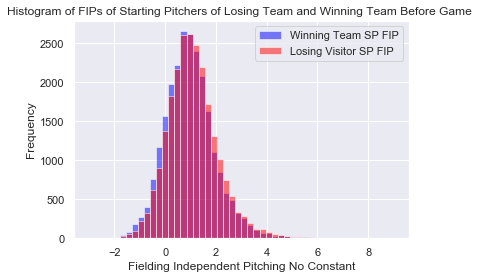

In [31]:
plt.hist(tempSP_FIPs['winnersSP_FIPs'], bins = 50, color = 'blue', alpha=0.5, range = [-3,9], label='Winning Team SP FIP')
plt.hist(tempSP_FIPs['losersSP_FIPs'], bins = 50,color = 'red', alpha=0.5, range = [-3,9],label='Losing Visitor SP FIP')
plt.title('Histogram of FIPs of Starting Pitchers of Losing Team and Winning Team Before Game ')
plt.xlabel('Fielding Independent Pitching No Constant')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

In [32]:
z, p_z = ztest(tempSP_FIPs['winnersSP_FIPs'], tempSP_FIPs['losersSP_FIPs'], alternative = 'smaller')

print('z-score: ', z)
print('p-value: ', p_z)

z-score:  -12.60560786320209
p-value:  9.832529044138253e-37


Again we have a p-value well below the significance level of 0.01, so we can reject the null hypothesis.  There is a statistically significane difference between the FIP of the starting pitchers of the team that wins and that loses.  On average, the starting pitcher on the team that wins has a lower (better) FIP.

## Identifying Collinear Variables

In [33]:
numeric_cols = gamelogs._get_numeric_data()
#numeric_cols = numeric_cols[numeric_cols.value_counts > 7]
#numeric_cols = numeric_cols.columns.drop(list(numeric_cols.filter(regex=['Position','Avg','Number']))
#numeric_cols = numeric_cols.drop(cols_to_drop + ['ForfeitInfo'], axis=1)
print(numeric_cols.columns[:50])
print(numeric_cols.columns[51:100])
print(numeric_cols.columns[101:150])
print(numeric_cols.columns[151:])

Index(['DoubleHeader', 'VisitingTeamGameNumber', 'HomeTeamGameNumber',
       'VisitorRunsScored', 'HomeRunsScored', 'LengthInOuts', 'ForfeitInfo',
       'Attendance', 'Duration', 'VisitorAB', 'VisitorH', 'VisitorD',
       'VisitorT', 'VisitorHR', 'VisitorRBI', 'VisitorSH', 'VisitorSF',
       'VisitorHBP', 'VisitorBB', 'VisitorIBB', 'VisitorK', 'VisitorSB',
       'VisitorCS', 'VisitorGDP', 'VisitorCI', 'VisitorLOB', 'VisitorPitchers',
       'VisitorER', 'VisitorTER', 'VisitorWP', 'VisitorBalks', 'VisitorPO',
       'VisitorA', 'VisitorE', 'VisitorPassed', 'VisitorDB', 'VisitorTP',
       'HomeAB', 'HomeH', 'HomeD', 'HomeT', 'HomeHR', 'HomeRBI', 'HomeSH',
       'HomeSF', 'HomeHBP', 'HomeBB', 'HomeIBB', 'HomeK', 'HomeSB'],
      dtype='object')
Index(['HomeGDP', 'HomeCI', 'HomeLOB', 'HomePitchers', 'HomeER', 'HomeTER',
       'HomeWP', 'HomeBalks', 'HomePO', 'HomeA', 'HomeE', 'HomePassed',
       'HomeDB', 'HomeTP', 'HomeWin', 'CG_HSP', 'GF_HSP', 'W_HSP', 'L_HSP',
       'Sho_HSP',

Now let's narrow it down to only columns containing avergages because these are the only columns we can use for prediction. 

In [34]:
cols_to_keep = [col for col in numeric_cols.columns if col.startswith(('Avg', 'pct', 'HomeWin'))]

In [35]:
cols_to_keep = numeric_cols[cols_to_keep]
print(cols_to_keep.shape)
cols_to_keep.columns

(24298, 148)


Index(['HomeWin', 'pctCG_HSP', 'pctGF_HSP', 'pctW_HSP', 'pctL_HSP',
       'pctSho_HSP', 'AvgIP_HSP', 'AvgH_HSP', 'AvgR_HSP', 'AvgER_HSP',
       ...
       'AvgBABIP_V', 'AvgPitchBABIP_H', 'AvgPitchBABIP_V', 'AvgAper9_H',
       'AvgAper9_V', 'AvgAttendance', 'AvgRunDiffAtHome_H',
       'AvgRunDiffOnRoad_V', 'pctWinAtHome_H', 'pctWinOnRoad_V'],
      dtype='object', length=148)

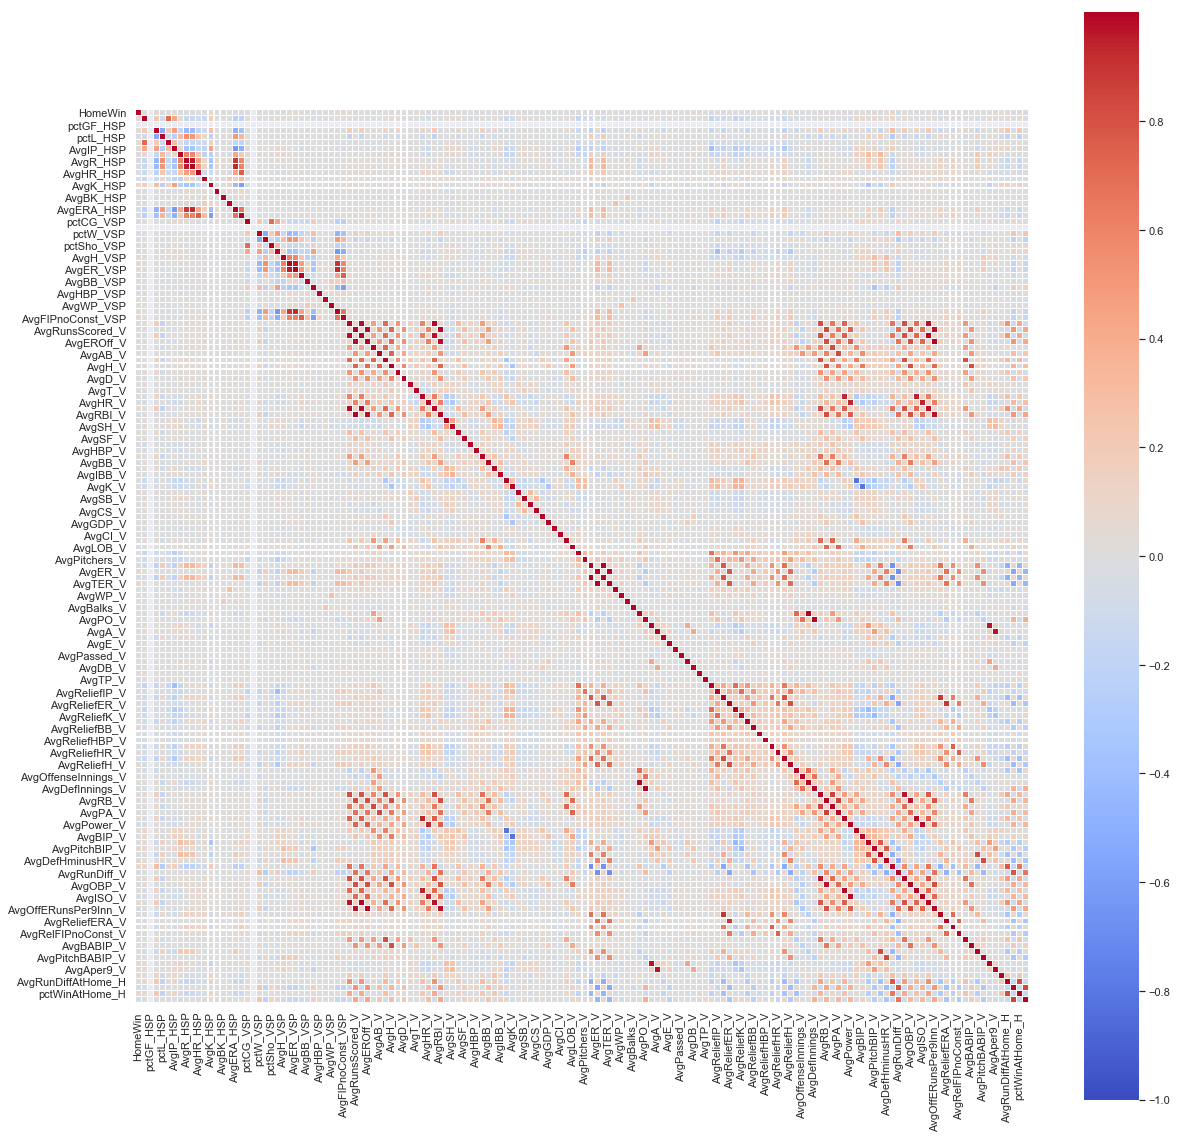

In [36]:
plt.figure(figsize=(20,20))
corr_mat = cols_to_keep.corr()
cbar_kws = { 'ticks' : list(np.arange(-1,1,0.2)) }
sns.heatmap(corr_mat, cmap='coolwarm', vmin=-1, cbar_kws=cbar_kws, linewidth=.1, square=True)

In [37]:
more_to_drop = [col for col in cols_to_keep.columns if col.startswith('AvgFIPnum')]
cols_to_keep = cols_to_keep.drop(['pctGF_HSP', 'pctGF_VSP'], axis=1)
cols_to_keep = cols_to_keep.drop(more_to_drop, axis=1)

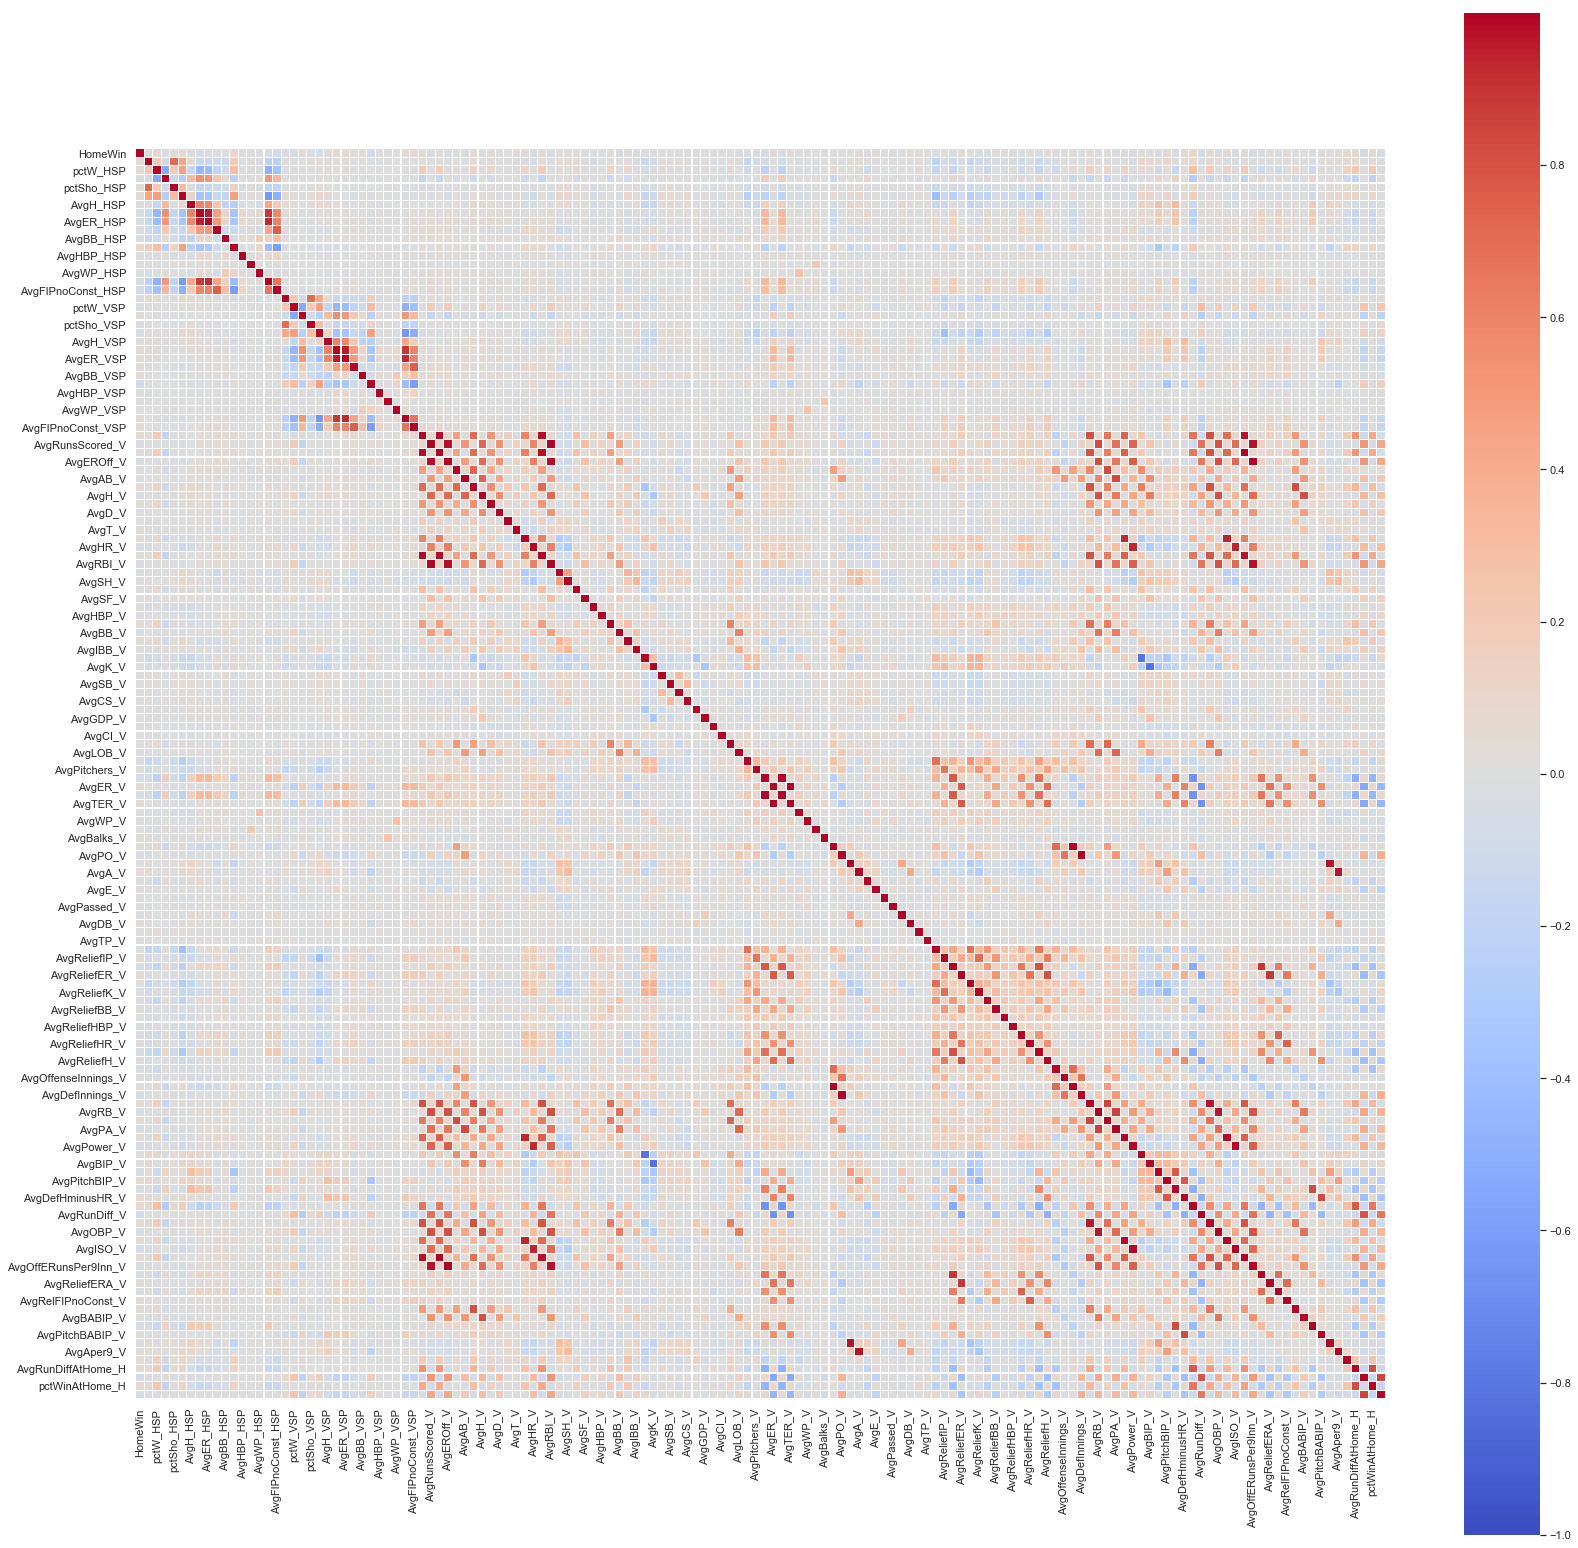

In [38]:
plt.figure(figsize=(28,28))
corr_mat = cols_to_keep.corr()
cbar_kws = { 'ticks' : list(np.arange(-1,1,0.2)) }
sns.heatmap(corr_mat, cmap='coolwarm', vmin=-1, cbar_kws=cbar_kws, linewidth=.1, square=True)

This heat map is quite large, and hard to read but at first glance we see that no features are highly correlated with the target of home win.  

In [39]:
sorted_corrs = cols_to_keep.corr().unstack().sort_values(ascending=False)
sorted_corrs[sorted_corrs==1].shape

(146,)

In [40]:
high_corrs = sorted_corrs[(abs(sorted_corrs) > 0.7) & (abs(sorted_corrs) !=1)]
print(high_corrs.shape[0])
high_corrs.head(10)

232


AvgDefInnings_V       AvgPO_V                 0.999964
AvgPO_V               AvgDefInnings_V         0.999964
AvgDefInnings_H       AvgPO_H                 0.999963
AvgPO_H               AvgDefInnings_H         0.999963
AvgER_V               AvgTER_V                0.999673
AvgTER_V              AvgER_V                 0.999673
AvgTER_H              AvgER_H                 0.999623
AvgER_H               AvgTER_H                0.999623
AvgOffERunsPer9Inn_V  AvgEROff_V              0.993877
AvgEROff_V            AvgOffERunsPer9Inn_V    0.993877
dtype: float64

In [41]:
#each set of correlated pairs is duplicated so let's make sure there are no sets of 
# unique pairs with the same correlation and drop the duplicates
val_counts = high_corrs.value_counts()
val_counts[val_counts > 2]

Series([], dtype: int64)

In [42]:
high_corrs = high_corrs.drop_duplicates()

In [43]:
high_corrs.shape[0]

116

In [44]:
high_corrs[:51]

AvgDefInnings_V       AvgPO_V                 0.999964
AvgDefInnings_H       AvgPO_H                 0.999963
AvgER_V               AvgTER_V                0.999673
AvgTER_H              AvgER_H                 0.999623
AvgOffERunsPer9Inn_V  AvgEROff_V              0.993877
AvgOffERunsPer9Inn_H  AvgEROff_H              0.993567
AvgRunsScored_V       AvgRBI_V                0.992259
AvgRBI_H              AvgRunsScored_H         0.991716
AvgPower_H            AvgISO_H                0.991334
AvgPower_V            AvgISO_V                0.991034
AvgRBI_V              AvgEROff_V              0.980459
AvgEROff_V            AvgRunsScored_V         0.979736
AvgRunsScored_H       AvgEROff_H              0.979557
AvgEROff_H            AvgRBI_H                0.979523
AvgOffERunsPer9Inn_V  AvgRBI_V                0.974073
AvgA_V                AvgAper9_V              0.973535
AvgOffERunsPer9Inn_H  AvgRBI_H                0.972908
AvgA_H                AvgAper9_H              0.972802
AvgOffERun

In [45]:
high_corrs[51:101]

AvgRB_V               AvgH_V                  0.808343
AvgReliefER_H         AvgReliefH_H            0.805965
AvgH_V                AvgOBP_V                0.805764
AvgRunsScored_H       AvgOBP_H                0.805615
AvgOBP_V              AvgEROff_V              0.804916
AvgRBI_H              AvgRB_H                 0.804893
AvgEROff_H            AvgRB_H                 0.802071
AvgOBP_H              AvgOffERunsPer9Inn_H    0.801546
AvgOBP_V              AvgRBI_V                0.801286
AvgOBP_H              AvgEROff_H              0.798535
AvgH_H                AvgRB_H                 0.798200
AvgOBP_H              AvgH_H                  0.797853
                      AvgRBI_H                0.795301
AvgRB_V               AvgOffERunsPer9Inn_V    0.794970
AvgRunDiffOnRoad_V    AvgRunDiff_V            0.788934
AvgOffERunsPer9Inn_H  AvgRB_H                 0.780877
AvgER_V               AvgReliefER_V           0.779680
AvgPitchBIP_H         AvgDefHminusHR_H        0.779092
AvgRunDiff

In [46]:
high_corrs[101:]

pctSho_HSP            pctCG_HSP         0.713457
AvgRBI_V              AvgISO_V          0.712096
AvgISO_H              AvgRBI_H          0.711034
AvgLOB_H              AvgRB_H           0.709857
AvgH_H                AvgRBI_H          0.708200
pctSho_VSP            pctCG_VSP         0.707600
AvgOBP_V              AvgPA_V           0.707397
AvgOffERunsPer9Inn_V  AvgH_V            0.706227
AvgER_V               AvgReliefH_V      0.705037
AvgRelFIPnoConst_V    AvgReliefERA_V    0.704661
AvgReliefH_V          AvgTER_V          0.703538
AvgEROff_H            AvgH_H            0.702254
AvgReliefIP_H         AvgReliefK_H      0.700810
AvgBIP_H              AvgK_H           -0.817089
AvgK_V                AvgBIP_V         -0.821009
dtype: float64

In [47]:
OBP_RBI = gamelogs[['AvgOBP_H','AvgRBI_H']].corr()
OBP_RBI

,AvgOBP_H,AvgRBI_H
AvgOBP_H,1.000000,0.795301
AvgRBI_H,0.795301,1.000000


Many of these are trivially correlated for example team eraned runs (AvgTER) and individual earned runs(AvgER) as well as the ones that are functions of other variables, for example BIP (balls in play) is a function of K (strikeouts).

In [48]:
cols_to_keep.columns[0:50]

Index(['HomeWin', 'pctCG_HSP', 'pctW_HSP', 'pctL_HSP', 'pctSho_HSP',
       'AvgIP_HSP', 'AvgH_HSP', 'AvgR_HSP', 'AvgER_HSP', 'AvgHR_HSP',
       'AvgBB_HSP', 'AvgK_HSP', 'AvgHBP_HSP', 'AvgBK_HSP', 'AvgWP_HSP',
       'AvgERA_HSP', 'AvgFIPnoConst_HSP', 'pctCG_VSP', 'pctW_VSP', 'pctL_VSP',
       'pctSho_VSP', 'AvgIP_VSP', 'AvgH_VSP', 'AvgR_VSP', 'AvgER_VSP',
       'AvgHR_VSP', 'AvgBB_VSP', 'AvgK_VSP', 'AvgHBP_VSP', 'AvgBK_VSP',
       'AvgWP_VSP', 'AvgERA_VSP', 'AvgFIPnoConst_VSP', 'AvgRunsScored_H',
       'AvgRunsScored_V', 'AvgEROff_H', 'AvgEROff_V', 'AvgAB_H', 'AvgAB_V',
       'AvgH_H', 'AvgH_V', 'AvgD_H', 'AvgD_V', 'AvgT_H', 'AvgT_V', 'AvgHR_H',
       'AvgHR_V', 'AvgRBI_H', 'AvgRBI_V', 'AvgSH_H'],
      dtype='object')

In [49]:
cols_to_keep.columns[50:100]

Index(['AvgSH_V', 'AvgSF_H', 'AvgSF_V', 'AvgHBP_H', 'AvgHBP_V', 'AvgBB_H',
       'AvgBB_V', 'AvgIBB_H', 'AvgIBB_V', 'AvgK_H', 'AvgK_V', 'AvgSB_H',
       'AvgSB_V', 'AvgCS_H', 'AvgCS_V', 'AvgGDP_H', 'AvgGDP_V', 'AvgCI_H',
       'AvgCI_V', 'AvgLOB_H', 'AvgLOB_V', 'AvgPitchers_H', 'AvgPitchers_V',
       'AvgER_H', 'AvgER_V', 'AvgTER_H', 'AvgTER_V', 'AvgWP_H', 'AvgWP_V',
       'AvgBalks_H', 'AvgBalks_V', 'AvgPO_H', 'AvgPO_V', 'AvgA_H', 'AvgA_V',
       'AvgE_H', 'AvgE_V', 'AvgPassed_H', 'AvgPassed_V', 'AvgDB_H', 'AvgDB_V',
       'AvgTP_H', 'AvgTP_V', 'AvgReliefIP_H', 'AvgReliefIP_V', 'AvgReliefER_H',
       'AvgReliefER_V', 'AvgReliefK_H', 'AvgReliefK_V', 'AvgReliefBB_H'],
      dtype='object')

In [50]:
cols_to_keep.columns[101:]

Index(['AvgReliefHBP_H', 'AvgReliefHBP_V', 'AvgReliefHR_H', 'AvgReliefHR_V',
       'AvgReliefH_H', 'AvgReliefH_V', 'AvgOffenseInnings_H',
       'AvgOffenseInnings_V', 'AvgDefInnings_H', 'AvgDefInnings_V', 'AvgRB_H',
       'AvgRB_V', 'AvgPA_H', 'AvgPA_V', 'AvgPower_H', 'AvgPower_V', 'AvgBIP_H',
       'AvgBIP_V', 'AvgPitchBIP_H', 'AvgPitchBIP_V', 'AvgDefHminusHR_H',
       'AvgDefHminusHR_V', 'AvgRunDiff_H', 'AvgRunDiff_V', 'AvgOBP_H',
       'AvgOBP_V', 'AvgISO_H', 'AvgISO_V', 'AvgOffERunsPer9Inn_H',
       'AvgOffERunsPer9Inn_V', 'AvgReliefERA_H', 'AvgReliefERA_V',
       'AvgRelFIPnoConst_H', 'AvgRelFIPnoConst_V', 'AvgBABIP_H', 'AvgBABIP_V',
       'AvgPitchBABIP_H', 'AvgPitchBABIP_V', 'AvgAper9_H', 'AvgAper9_V',
       'AvgAttendance', 'AvgRunDiffAtHome_H', 'AvgRunDiffOnRoad_V',
       'pctWinAtHome_H', 'pctWinOnRoad_V'],
      dtype='object')

## Is On-Base Percentage correlated with Isolated Power?
We will just look at the home team for now.

HYPOTHESIS TEST: <br>
Null hypothesis: There is no correlation between the on-base percentage and isolated power. <br>
$H_{0}$: $\rho$ = 0 <br>
Alt. hypothesis: There is a correlation between the on-base percentage and isolated power. <br>
$H_{A}$: $\rho$ $\neq$ 0 <br>
$\alpha$ = 0.01

In [51]:
OBP_ISO = gamelogs[['AvgOBP_H','AvgISO_H']]
OBP_ISO.dropna(axis=0,inplace=True)
OBP = OBP_ISO['AvgOBP_H']
ISO = OBP_ISO['AvgISO_H']

/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


/Users/sineadoconnor/miniconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


Text(25.0, 0.5, 'ISO')

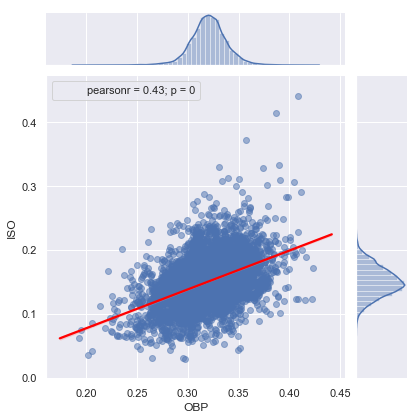

In [52]:
sns.set()

jplot = sns.jointplot('AvgOBP_H', 'AvgISO_H', data = OBP_ISO, kind = 'reg', scatter_kws = {'alpha': 0.5}, line_kws = {'color':'red'})
jplot.annotate(stats.pearsonr)
plt.xlabel('OBP')
plt.ylabel('ISO')

In [53]:
obs_corr = np.corrcoef(OBP, ISO)[0,1]
print('Observed correlation between OBP and ISO: ', obs_corr)

perm_reps = np.empty(100000)
for i in range(100000):
    perm_ISO = np.random.permutation(OBP_ISO['AvgISO_H'])
    perm_reps[i] = np.corrcoef(OBP, perm_ISO)[0,1]

p_value = sum(perm_reps >= obs_corr)/100000    
print('p-value: ', p_value)


Observed correlation between OBP and ISO:  0.4273209213214118
p-value:  0.0


Out of 100,000 permutations no permutation resulted in a correlation coefficient as extreme as the observed correlation of 0.4273 so the p-value is very low.  We can reject the null hypothesis.  There is a statistically significant correlation between OBP ans ISO.  There is a moderate linear relationship between OBP and ISO.